In [1]:
import numpy as np
import pandas as pd
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
%matplotlib inline

In [2]:
import plotly 
plotly.tools.set_credentials_file(username='anikamal', api_key='BSWmdlJFrie24url3SK4')

In [3]:
df = pd.read_csv("data\\prescriber-info.csv")
# load the file as pandas dataframe
opiate_df = pd.read_csv("data\\opioids.csv")
# read the opiate drug file

# Dropping of drugs that are opiate

In [3]:
opiate = []
for col in opiate_df:
    for drug in opiate_df[col]:
        drug = drug.replace(" ", ".")
        drug = drug.replace("-", ".")
        for given in df.columns:
            if drug == given:
                opiate.append(given)
print(opiate)
df.drop(opiate, axis = 1, inplace = True)
df.head(5)

['ACETAMINOPHEN.CODEINE', 'FENTANYL', 'HYDROCODONE.ACETAMINOPHEN', 'HYDROMORPHONE.HCL', 'HYDROMORPHONE.HCL', 'METHADONE.HCL', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE.ER', 'OXYCODONE.HCL', 'OXYCODONE.ACETAMINOPHEN', 'OXYCONTIN', 'TRAMADOL.HCL', 'MORPHINE.SULFATE', 'TRAMADOL.HCL', 'HYDROMORPHONE.HCL', 'METHADONE.HCL', 'METHADONE.HCL', 'FENTANYL', 'HYDROMORPHONE.HCL', 'FENTANYL', 'HYDROMORPHONE.HCL', 'HYDROMORPHONE.HCL', 'MORPHINE.SULFATE', 'METHADONE.HCL', 'METHADONE.HCL', 'METHADONE.HCL', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE', 'MORPHINE.SULFATE', 'OXYCODONE.HCL', 'OXYCODONE.HCL', 'OXYCODONE.HCL', 'OXYCODONE.HCL', 'OXYCODONE.HCL', 'TRAMADOL.HCL', 'FENTANYL', 'TRAMADOL.HCL', 'TRAMADOL.HCL', 'TRAMADOL.HCL', 'TRAMADOL.HCL']


,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


# Down sampling of data

In [4]:
zero = df[df['Opioid.Prescriber'] == 0]
one = df[df['Opioid.Prescriber'] == 1]
# get the data of each class
if len(one) > len(zero):
    index = one.index[len(zero):]
else:
    index = zero.index[:len(one)]

df.drop(index, inplace = True)
# drop the rows to achieve balanced class labels

#  User defined functions


In [5]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def performance_metrics(actual, predict):
    """
    This function evaluates the performance metrics 
    needed.
    """
    
    accuracy = np.mean(actual == predict)
    # compute accuracy
    print("Accuracy: {0}%".format(accuracy*100))
    print("\nReport")
    print(metrics.classification_report(actual, predict))
    # classification report
    matrix = (metrics.confusion_matrix(actual, predict))
    plot_confusion_matrix(matrix, ['0', '1'])
    # plot the confusion matrix
    fpr, tpr, threshold = metrics.roc_curve(actual, predict)
    # values to plot ROC curve
    print("FPR")
    print(fpr)
    print("TPR")
    print(tpr)
    print("Thresholds")
    print(threshold)
    auc = round(metrics.roc_auc_score(actual, predict), 2)
    # get the area under curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0})'.format(auc), color = 'green')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def feature_graph(x, y, k = 10, filename = None):
    """
    Helps to plot the feature and its score
    """

    trace = go.Bar(
                   x = [i[0] for i in feature_imp[:k]],
                   y = [i[1] for i in feature_imp[:k]],
                   )
    data = [trace]
    layout = go.Layout(
        title='Top ten feature-scores',
        xaxis=dict(
            title = "Features",
            tickangle = 40,
            tickfont=dict(
                size=8,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        yaxis=dict(
            title='Feature score',
            titlefont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            ),
            tickfont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        plot_bgcolor = 'rgba(100, 100, 100, 0.04)'
    )
    
    fig = go.Figure(data=data, layout = layout)
    return py.iplot(fig, filename = filename)

# Data Preprocessing

In [8]:
gender = df['Gender']
state = df['State']
specialty = df['Specialty']
columns = ['NPI', 'Credentials', 'Gender', 'State', 'Specialty']
# columns to be dropped
df.drop(labels = columns, axis = 1, inplace = True)
# drop the columns
df.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,35,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,17,28,0,0,0,1


In [9]:
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features

# Decision Tree Model

In [10]:
cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
# define how data is to be splitted for CV

## Parameters to experiment

In [37]:
params = {'max_depth':[i for i in range(1, 50)], 'criterion':['entropy']}
# different combinations of parameters to be tested

In [38]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid = params, n_jobs = -1, cv = cv)
# test decision tree on the data with the parameters above
clf.fit(features.values, labels.values)
# fit data to classifier

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'criterion': ['entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 13}

In [40]:
best_clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = clf.best_params_['max_depth'])
# best classifier
best_clf.fit(features.values, labels.values)
# fit data to classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Validation curve

In [41]:
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(criterion="entropy"), features.values,
                                            labels.values, param_name = "max_depth", param_range  = np.linspace(1, 50, num = 50),
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

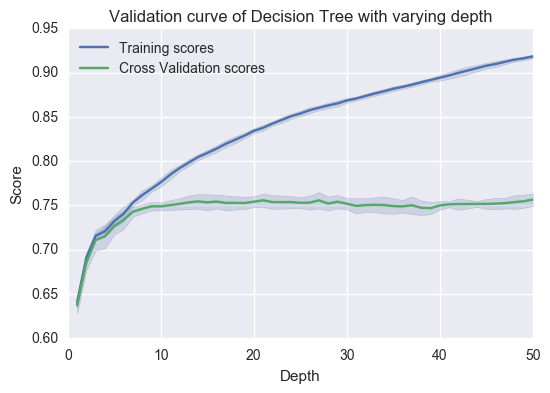

In [42]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(np.linspace(1, 50, num = 50), train_score_mean, label = "Training scores")
plt.plot(np.linspace(1, 50, num = 50), test_score_mean, label = "Cross Validation scores")
plt.fill_between(np.linspace(1, 50, num = 50), train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(np.linspace(1, 50, num = 50), test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with varying depth")
plt.xlabel("Depth")
plt.ylabel("Score")

## Learning Curve

In [43]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['max_depth']),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

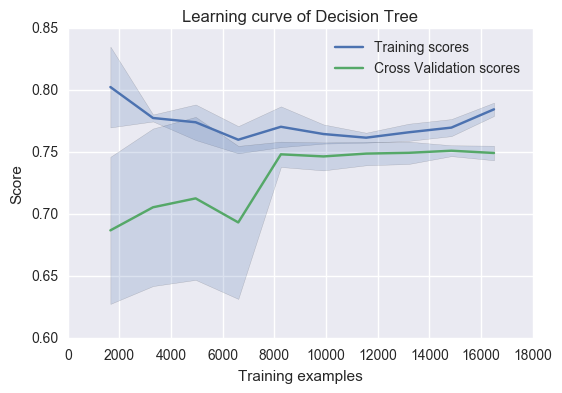

In [18]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Decision Tree")
plt.xlabel("Training examples")
plt.ylabel("Score")

In [19]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

# Performance Metrics

Accuracy: 75.32971295577967%

Report
             precision    recall  f1-score   support

          0       0.70      0.87      0.78     10312
          1       0.83      0.63      0.72     10312

avg / total       0.77      0.75      0.75     20624

Confusion matrix, without normalization
[[8988 1324]
 [3764 6548]]
FPR
[ 0.         0.1283941  1.       ]
TPR
[ 0.          0.63498836  1.        ]
Thresholds
[2 1 0]


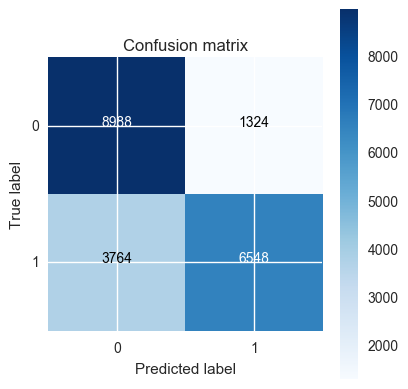

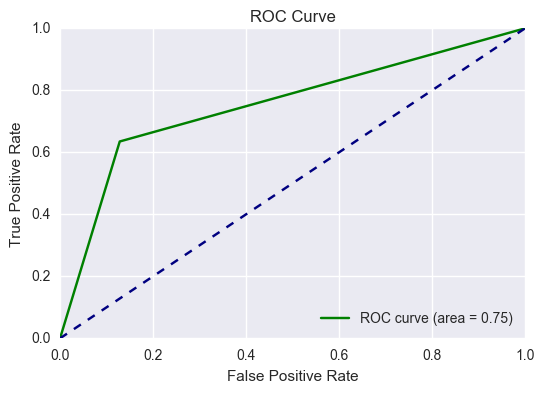

In [21]:
performance_metrics(labels, predict)
# function call to report performance metrics

## Top 10 features

In [22]:
feature_dict = dict(zip(features.columns, best_clf.feature_importances_))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-tree-without-feature-engg")
# plot the data

# Bagging wrapper

In [23]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['max_depth']))

param_range = list(range(1, 12, 5))
bag_train_scores, bag_test_scores = validation_curve(bagging_classifier, features.values,
                                            labels.values, param_name = "n_estimators", param_range  = param_range,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

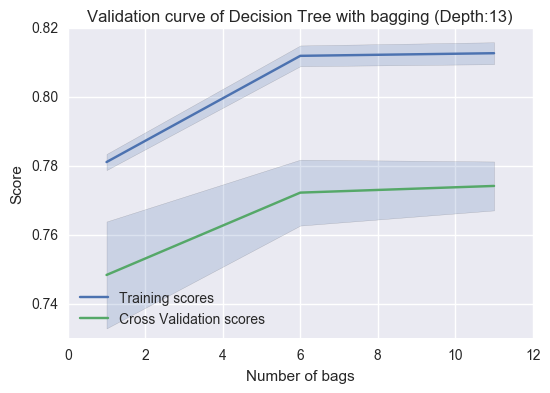

In [24]:
train_score_mean = np.mean(bag_train_scores, axis = 1)
train_score_std = np.std(bag_train_scores, axis = 1)
test_score_mean = np.mean(bag_test_scores, axis = 1)
test_score_std = np.std(bag_test_scores, axis = 1)

plt.plot(param_range, train_score_mean, label = "Training scores")
plt.plot(param_range, test_score_mean, label = "Cross Validation scores")
plt.fill_between(param_range, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(param_range, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with bagging (Depth:{0})".format(clf.best_params_['max_depth']))
plt.xlabel("Number of bags")
plt.ylabel("Score")

In [44]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['max_depth']),
                                      n_estimators = 6)
# bagging classifier
bagging_classifier.fit(features.values, labels.values)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=6, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [45]:
predict = cross_val_predict(bagging_classifier, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

Accuracy: 77.28859581070597%

Report
             precision    recall  f1-score   support

          0       0.72      0.88      0.80     10312
          1       0.85      0.66      0.74     10312

avg / total       0.79      0.77      0.77     20624

Confusion matrix, without normalization
[[9125 1187]
 [3497 6815]]
FPR
[ 0.          0.11510861  1.        ]
TPR
[ 0.          0.66088053  1.        ]
Thresholds
[2 1 0]


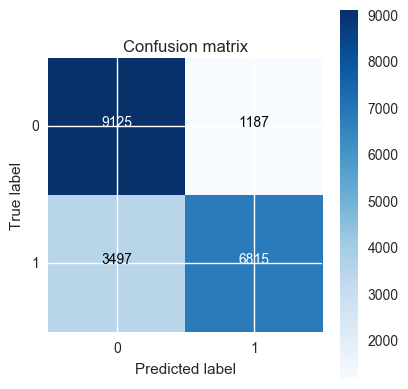

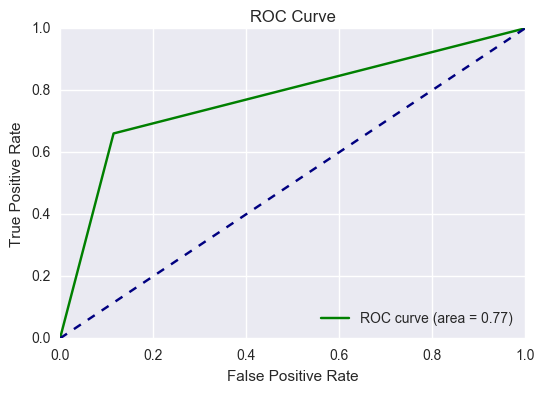

In [46]:
performance_metrics(labels, predict)
# function call to report performance metrics


# Logistic Regression

In [25]:
from sklearn import linear_model
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features
features.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,17,28,0,0,0


In [26]:
c_val = [0.001, 0.01, 0.1, 1, 2]
# C values
params = {"C":c_val}
# parameters to be tested with
clf = GridSearchCV(linear_model.LogisticRegression(), param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [29]:
clf.best_params_

{'C': 0.001}

# Validation curve

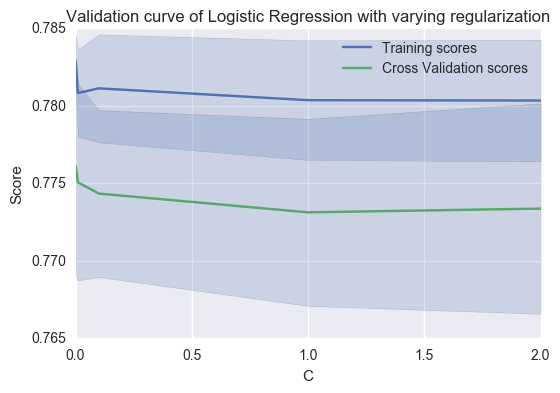

In [28]:
train_scores, test_scores = validation_curve(linear_model.LogisticRegression(), features.values,
                                            labels.values, param_name = "C", param_range  = c_val,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(c_val, train_score_mean, label = "Training scores")
plt.plot(c_val, test_score_mean, label = "Cross Validation scores")
plt.fill_between(c_val, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(c_val, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Logistic Regression with varying regularization")
plt.xlabel("C")
plt.ylabel("Score")

# Learning curve

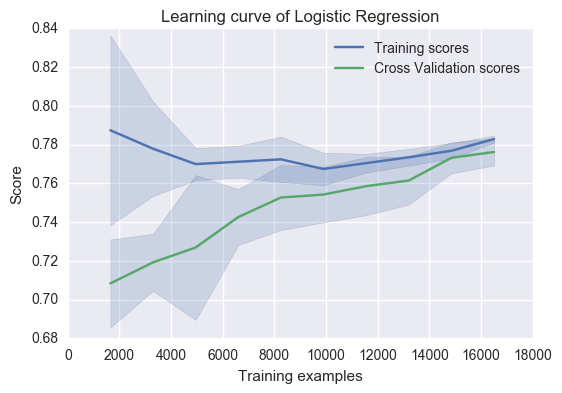

In [30]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(linear_model.LogisticRegression(C = clf.best_params_["C"]),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")

In [32]:
best_clf = linear_model.LogisticRegression(C = clf.best_params_['C'])
best_clf.fit(features.values, labels.values)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

# Performance metrics

Accuracy: 77.60861132660978%

Report
             precision    recall  f1-score   support

          0       0.73      0.88      0.80     10312
          1       0.85      0.67      0.75     10312

avg / total       0.79      0.78      0.77     20624

Confusion matrix, without normalization
[[9057 1255]
 [3363 6949]]
FPR
[ 0.          0.12170287  1.        ]
TPR
[ 0.         0.6738751  1.       ]
Thresholds
[2 1 0]


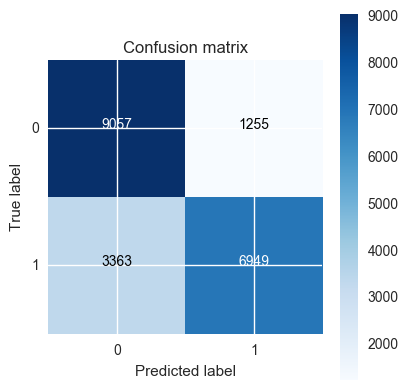

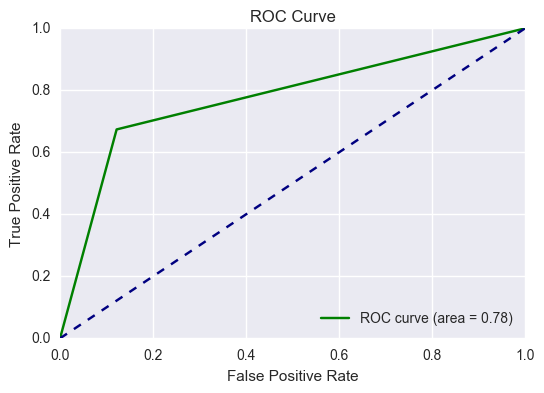

In [34]:
performance_metrics(labels, predict)
# function call to report performance metrics

# top 10 features

In [36]:
feature_dict = dict(zip(features.columns, best_clf.coef_[0]))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-logistic-without-feature-engg")
# plot the data